<a href="https://colab.research.google.com/github/trungsi/DS-project---Road-accidents-in-France/blob/master/Linear_regressions_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/DataScience project/Road accidents - model 2.csv', 'r', encoding='ISO-8859-1') as f:
  df = pd.read_csv(f)

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-0739206d9ea7>:6: DtypeWarning: Columns (7,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312230 entries, 0 to 2312229
Data columns (total 33 columns):
 #   Column   Dtype  
---  ------   -----  
 0   grav     float64
 1   place    float64
 2   catu     int64  
 3   sexe     float64
 4   trajet   float64
 5   secu     float64
 6   locp     float64
 7   actp     object 
 8   etatp    float64
 9   senc     float64
 10  catv     float64
 11  occutc   float64
 12  obs      float64
 13  obsm     float64
 14  choc     float64
 15  manv     float64
 16  catr     int64  
 17  circ     float64
 18  prof     float64
 19  plan     float64
 20  lartpc   float64
 21  larrout  float64
 22  surf     float64
 23  infra    float64
 24  situ     float64
 25  env1     float64
 26  lum      float64
 27  agg      int64  
 28  int      float64
 29  atm      float64
 30  col      float64
 31  dep      object 
 32  age      float64
dtypes: float64(28), int64(3), object(2)
memory usage: 582.2+ MB


1.0    0.410367
4.0    0.363716
3.0    0.199277
2.0    0.026613
0.0    0.000026
Name: grav, dtype: float64


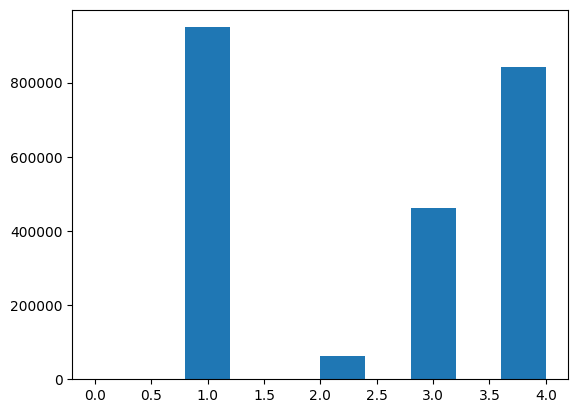

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

print(df.grav.value_counts(normalize=True))

plt.hist(df.grav);

# Data is imbalanced. Death class is only 2%. Will be difficult to predict this class. Should we use imbalance technique ?

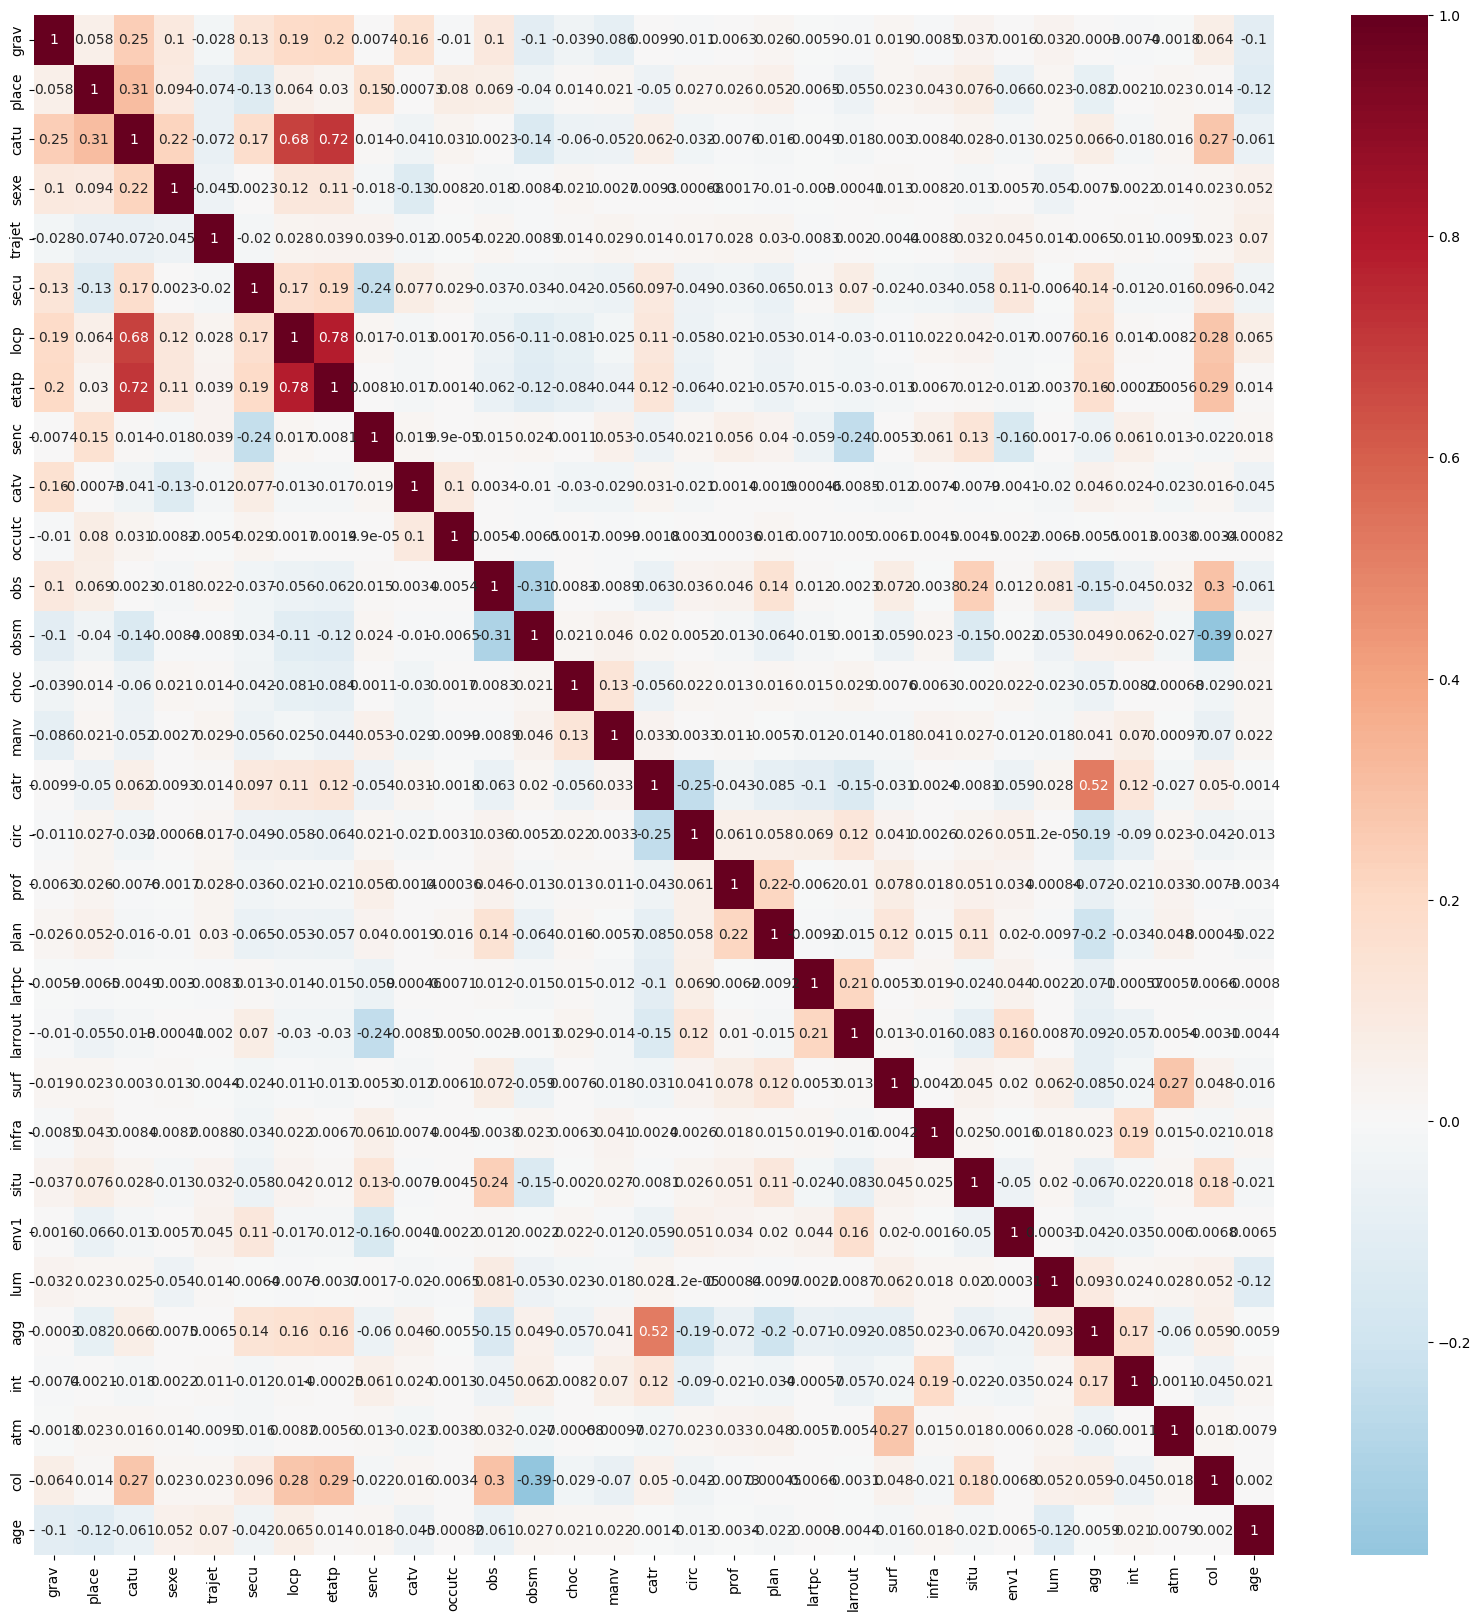

In [3]:
# remove class 0 value 
df = df[df.grav != 0]

import seaborn as sns

plt.figure(figsize=(20,20))
# most of all features are still considered as continuous (while they are categorical indeed)
# so we can plot correlation map 
sns.heatmap(df.corr(),  annot=True, cmap="RdBu_r", center =0);

# catu (category of usagers) is highly influent on gravity. 
# etatp (pedestrian is sole or within group) is surprisingly the second most important feature. 
# locp (location of pedestrian) comes next as the third important feature.
# Next one is catv (category of vehicule)


# There're 2M records which is not big database as such. However training is not possible even with simple linear regression. 
- Get OOM error.
- It does not work with 12G of RAM on Google Colab.
- Need to reduce size of the training dataset. How does it impact training result ?
-  Maybe to test with Spark on local machine ?

# First technique is to category data type (pandas) instead of string which allow shrink the volume of dataset from 3.8G to 170M

In [4]:
columns = df.columns.drop(['age', 'lartpc', 'larrout', 'occutc', 'grav'])
df[columns] = df[columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312170 entries, 0 to 2312229
Data columns (total 33 columns):
 #   Column   Dtype   
---  ------   -----   
 0   grav     float64 
 1   place    category
 2   catu     category
 3   sexe     category
 4   trajet   category
 5   secu     category
 6   locp     category
 7   actp     category
 8   etatp    category
 9   senc     category
 10  catv     category
 11  occutc   float64 
 12  obs      category
 13  obsm     category
 14  choc     category
 15  manv     category
 16  catr     category
 17  circ     category
 18  prof     category
 19  plan     category
 20  lartpc   float64 
 21  larrout  float64 
 22  surf     category
 23  infra    category
 24  situ     category
 25  env1     category
 26  lum      category
 27  agg      category
 28  int      category
 29  atm      category
 30  col      category
 31  dep      category
 32  age      float64 
dtypes: category(28), float64(5)
memory usage: 169.8 MB


# It's still not possible to train with this number of records using Rigde on Google Colab.
- The next technique is to reduce the number of rows in training set using sampling (dataframe.sample)
- The sampling below will try to keep the weight of target classes.
- However, the proportion of minor class (death in this case) is reduced 10 times (from 2% to 0.2%). There will be almost no chance to predict this class
- Need to reduce by 70% the size of training set to make it passed on Google Colab

In [5]:
grav_count = df.grav.value_counts(normalize=True)
grav_count = grav_count.reset_index().rename(columns={'grav': 'grav_count', 'index': 'grav'})
print(grav_count)

# dataset is too large for prediction
# try to do sampling by keeping sample proportion on gravity
df = pd.merge(df, grav_count, on='grav')
# is it enough to reduce size by 50%
# Still OOM
# df = df.sample(frac=0.5, weights='grav_count')
# try with 0.3
df = df.sample(frac=0.3, weights='grav_count')
# class 2 (death) proportion is reduced 10 times after pandas sampling
# need to revise sampling technique
print(df.grav.value_counts(normalize=True))


   grav  grav_count
0   1.0    0.410378
1   4.0    0.363725
2   3.0    0.199282
3   2.0    0.026614
1.0    0.482845
4.0    0.387508
3.0    0.127222
2.0    0.002425
Name: grav, dtype: float64


In [6]:
# separation of features and target variables
target = df.grav.astype('category') # convert to string for classification
feats = df.drop(columns=['grav'])


# Is it required to scale a few continous variables ?

In [7]:
# convert categorical variables to numeric using dummy
feats = pd.get_dummies(feats)
feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693651 entries, 1349939 to 1949154
Columns: 489 entries, occutc to dep_988
dtypes: float64(5), uint8(484)
memory usage: 351.9 MB


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=123)

# A technique to freeup memory is to dereference no longer used datasets. However, it's not possible to control when garbage collector will run.

In [9]:
#print(feats.value_counts())
#print(df.info(memory_usage='deep'))
# try to delete objects to free memory
del df
del feats
del target

# Training with Ridge and default params. This step has been tried several times with various training size to find out the appropriate size to work on Google Colab.

In [15]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

ridge_csf = RidgeClassifier()
ridge_csf.fit(X_train, y_train)
print('Score on test', ridge_csf.score(X_test, y_test))

y_pred = ridge_csf.predict(X_test)

print(classification_report(y_test, y_pred))

print(pd.crosstab(y_test, y_pred, rownames=['True grav'], colnames=['Predicted grav']))

Score on test 0.8245525513403638


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         1.0       0.77      0.93      0.84     67248
         2.0       0.00      0.00      0.00       332
         3.0       0.98      0.98      0.98     17527
         4.0       0.87      0.65      0.74     53624

    accuracy                           0.82    138731
   macro avg       0.65      0.64      0.64    138731
weighted avg       0.83      0.82      0.82    138731

Predicted grav    1.0    3.0    4.0
True grav                          
1.0             62348      0   4900
2.0                 0    332      0
3.0                 0  17263    264
4.0             18844      0  34780


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# As expected, class 2 (death) is never predicted due to low proportion.

# However, the result looks good on overall for other classes. 

# We observe that class 2 (death) was always predicted as class 3 (injured with hospitalization). Class 1 (not injured) and class 3 (slightly injured) are only confused with each other.

# So the model would perform very well if we could consider only two classes (eg: 1,4=not grave and 2,3=grave)

# However, if we have to predict the death scenario, we will need to try with other approaches

In [16]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import StratifiedKFold

ridge_csf_cv = RidgeClassifierCV(
    alphas=[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
    cv=StratifiedKFold())

ridge_csf_cv.fit(X_train, y_train)

print('train mean score', ridge_csf_cv.score(X_train, y_train))
print('test mean score', ridge_csf_cv.score(X_test, y_test))
print('best score', ridge_csf_cv.best_score_)
print('alpha', ridge_csf_cv.alpha_)

y_pred = ridge_csf_cv.predict(X_test)

print(pd.crosstab(y_test, y_pred))

train mean score 0.8253441937576588
test mean score 0.8245741759231895
best score 0.8250342391696102
alpha 0.5
col_0    1.0    3.0    4.0
grav                      
1.0    62350      0   4898
2.0        0    332      0
3.0        0  17263    264
4.0    18843      0  34781


# Long process of cross-validation does not show better results

# Can we expect complete GridSearch with all parameters would have better result ?

# Below we try to keep death cases with imbalance sampling techniques. 

# We could only use UnderSampling because training will not be possible with OverSampling due to technical limitation on Google Colab.

# Even the ClusterCentroids throws OOM, so only try with RandomUnderSampling

In [17]:
print(y_train.value_counts())
# try to use imbalance sampling technique to keep minor class (death)
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score

# OOM with ClusterCentroids
#X_cc, y_cc = ClusterCentroids().fit_resample(X_train, y_train)
#print(y_cc.value_counts())

X_ru, y_ru = RandomUnderSampler().fit_resample(X_train, y_train)
print(y_ru.value_counts())

ridge_csf.fit(X_ru, y_ru)
print('test score', ridge_csf.score(X_test, y_test))

y_pred = ridge_csf.predict(X_test)
print(pd.crosstab(y_test, y_pred))



1.0    267678
4.0    215171
3.0     70721
2.0      1350
Name: grav, dtype: int64
1.0    1350
2.0    1350
3.0    1350
4.0    1350
Name: grav, dtype: int64
test score 0.6953096279850934
col_0    1.0   2.0   3.0    4.0
grav                           
1.0    54744     0   529  11975
2.0        0   317    15      0
3.0      267  7485  7757   2018
4.0    17485     0  2496  33643


# death can now be predicted with few errors with class 3 (strongly injured).

# However, prediction error of class 3 as class 2 is high. Almost the same as true prediction.

# The errors with other classes look stable.